# Imports

In [33]:
from bs4 import BeautifulSoup
import urllib.request
from selenium import webdriver
import time
import pandas as pd

# Configure Scraper
For the value `n_workshop_pages`, go to https://workshops.ncl.ac.uk/occurrences/ and enter the largest number from the page selector at the bottom of the site, i.e, 6 in this example:

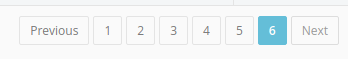

For year and term, enter whatever you want, it's just to name the spreadsheet at the end.

In [50]:
n_workshop_pages = 6
year = 2021
term = 'Fall'

# Launch WebDriver
This is going to launch the workshop page in a new Chrome window.

#### After it loads, log in and wait for workshops to load

Alternatively, uncomment the lines below and fill in username and password appropriately.

In [51]:
driver = webdriver.Chrome()
driver.get("https://workshops.ncl.ac.uk/occurrences/")


# driver.find_element_by_name('username').send_keys('username')
# driver.find_element_by_name('password').send_keys('password')
# driver.find_element_by_name('submit').click()
time.sleep(5)

# Scraper Functions
Load the parsers

In [52]:
def parseInfo(info):
    infoDict = {'Other Info':""}
    for i in info:
        if any([day in i for day in ["Monday","Tuesday","Wednesday","Thursday","Friday"]]):
            infoDict["Date"]=i
            
            #grab length estimation
            if "(" in i:
                length=(i.split("(")[1].split("hr)")[0]).split(":")
                
                if len(length)==2:
                    infoDict["Length"] = int(length[0])+int(length[1])/60
                elif 'mins' in length[0]:
                    infoDict["Length"] = int(length[0].split(" mins)")[0])
                else:
                    infoDict["Length"] = int(length[0])
            else:
                infoDict["Length"] = None

        elif "credits" in i:
            infoDict['Credits']=int(i.split()[0])
        elif "Fully booked" in i or "place" in i.lower():
            infoDict['Booking Status']=i
        else:
            infoDict['Other Info']+=i+" "
    return infoDict
        
def scrapePopup(count=0):
    try:
        title = driver.find_elements_by_xpath("//h3")
        info = driver.find_element_by_class_name("info")   
        buttons=driver.find_elements_by_xpath("//button")
        infoDict = parseInfo(info.text.split("\n"))
        infoDict['Title'] = [x.text for x in title][0]
        time.sleep(.1)
        [x.click() for x in buttons if 'Close' in x.text]
        return infoDict
    
    except:
        time.sleep(1)
        return scrapePopup()

# Scrape Workshops
This is the main loop that does everything, just sit and wait for this to click through everything


In [ ]:
workshops = []

for page in range(1,n_workshop_pages+1):
    print("==================== PAGE {} ====================".format(page))
    elems = driver.find_elements_by_class_name("remote_modal")
    for elem in elems:
        if "Review and Book" in elem.text or "Interested" in elem.text or ''==elem.text:
            continue
        print(repr(elem.text))
        elem.click()
        time.sleep(.35)
        workshops.append(scrapePopup())
        time.sleep(.3)
    
    driver.find_element_by_xpath("//a[text()='Next']").click()
    time.sleep(.25)

# Save
Pop all the data into a dataframe and save it

In [44]:
df=pd.DataFrame.from_records(workshops)
df = df.drop_duplicates()
df['Credits/Hour']=df['Credits']/df['Length']
df =df[['Title',"Length","Credits",'Credits/Hour',"Booking Status","Date","Other Info"]]
df = df[df['Credits'].notnull()]
df = df.sort_values("Credits/Hour",ascending=False)
df = df.reset_index(drop=True)
df.to_csv("Workshops_{}_{}.csv".format(term, year) ,index=False)
df

,Title,Length,Credits,Credits/Hour,Booking Status,Date,Other Info
0,Introduction to Learning and Teaching in Highe...,1.5,15.0,10.000000,Fully booked,Thursday 11th Nov 2021 - 10:30 (1:30 hr),https://ncl.instructure.com/courses/32027/fil...
1,Introduction to Learning and Teaching in Highe...,1.5,15.0,10.000000,Fully booked,Tuesday 14th Dec 2021 - 10:00 (1:30 hr),https://ncl.instructure.com/courses/32027/fil...
2,Introduction to Learning and Teaching in Highe...,1.5,15.0,10.000000,Fully booked,Wednesday 15th Dec 2021 - 13:30 (1:30 hr),https://ncl.instructure.com/courses/32027/fil...
3,Introduction to Learning and Teaching in Highe...,1.5,15.0,10.000000,Fully booked,Wednesday 10th Nov 2021 - 13:30 (1:30 hr),https://ncl.instructure.com/courses/32027/fil...
4,Presentation Skills (One to Ones),1.0,5.0,5.000000,Fully booked,Tuesday 2nd Nov 2021 - 09:30 (1 hr),
...,...,...,...,...,...,...,...
95,Lunchtime Mindfulness,30.0,2.0,0.066667,Places remaining,Friday 17th Dec 2021 - 12:30 (30 mins),Online via Zoom Michael Atkinson
96,Lunchtime Mindfulness,30.0,2.0,0.066667,Places remaining,Friday 10th Dec 2021 - 12:30 (30 mins),Online via Zoom Michael Atkinson
97,Lunchtime Mindfulness,30.0,2.0,0.066667,Places remaining,Friday 26th Nov 2021 - 12:30 (30 mins),Online via Zoom Michael Atkinson
98,Lunchtime Mindfulness,30.0,2.0,0.066667,Places remaining,Friday 22nd Oct 2021 - 12:30 (30 mins),Online via Zoom Michael Atkinson
